# Import 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.special import zeta
from scipy import integrate, interpolate
import pandas as pd
import time
import pickle
from scipy.interpolate import interp1d
import equations_and_constants as ec

# Constants & equations

## Fundamental Constants

In [5]:
# Masses, all in MeV
# Leptons
m_e, m_mu, m_tau = 0.510,105.7,1776.9
# Quarks
m_u, m_d, m_s, m_c, m_b, m_t = 2.3,4.8,95,1290,4180,173500
# Gauge bosons
m_W, m_Z, m_H = 80400,91200,125090
#Baryons
m_p, m_n = 938,939
# Mesons
m_pi0, m_pipm, m_K0, m_Kpm, m_eta, m_etaprime, m_rhopm, m_rho0, m_omega = 134.9766,139.570,497.614,493.677,547.862,957.78,775.11,775.26,782.65

# Other fundamental constants
Gf = 1.166 * 10**-5 *10**-6 #MeV**-2
grav = (1.22*10**22)**-2 #MeV**-2 
thetaW = np.arcsin(np.sqrt(0.2229))
fine_structure = 7.297352*10**-3
eta_B = 6*10**-10 #baryon asymmetry
f_pi = 131 # for pion channel decay
# QCD Transition temperature and width
T_qcd = 170
w_qcd = 10

# Unit conversions
MeVtoHz = 10**6/(6.582*10**-16) 

## Relativistic Degrees of Freedom: From Amol's diluton code

In [3]:
def compute_SM_relativistic_dof(T):
    """Calculate the relativistic degrees of freedom for the purposes of 
    computing the energy density. Valid up to arbitrarily high temperatures,
    and down to weak decoupling. Makes the approximation of g=0 once m>T."""
    #.....Enter particle characteristics, in the following order of particles: 
    #.....Leptons: e,mu,tau; Quarks: u,d,s,c,b,t; Gauge bosons (and Higgs): W+-,Z,H;
    #.....Baryons: p,n; Mesons: pi0,pi+-,K0,K+-,eta,eta',rho+-,rho0,omega
    #.....Particle masses in MeV
    masses = [m_e, m_mu, m_tau, m_u, m_d, m_s, m_c, m_b, m_t,m_W, m_Z,m_H,m_p,m_n,
                      m_pi0, m_pipm, m_K0, m_Kpm, m_eta, m_etaprime, m_rhopm, m_rho0, m_omega]

    # stat = ['f','f','f','f','f','f','f','f','f','b','b','b',
    #         'f','f','b','b','b','b','b','b','b','b','b']
    #.....Particle class: 'l' for lepton, 'q' for quark, 'g' for gauge bosons (and Higgs), 'h' for hadron
    particle_classes = ['l','l','l','q','q','q','q','q','q','g','g','g',
             'h','h','h','h','h','h','h','h','h','h','h']
    gdofs = [4.,4.,4.,12.,12.,12.,12.,12.,12.,6.,3.,1., 
            4.,4.,1.,2.,2.,2.,1.,1.,6.,3.,3.]

    #.....Statistical weights for massless or nearly massless particles (photons, neutrinos, gluons)
    gphot = 2. # Photon dofs
    gnuact = 3*2 # Active neutrino dofs: prior to weak decoupling 
    ggl = 16./(np.exp((T_qcd-T)/w_qcd)+1.) # Gluon dofs
    g_tot = gphot+gnuact+ggl
    
    # Massive particles approximation: simply set g_rel=0 when m<T. 
    # Also account for QCD phase transition
    for mass, particle_class, gdof in zip(masses, particle_classes, gdofs):
        if mass>T:
            gdof = 0
        if(particle_class == 'q'): 
            if T>0.1*T_qcd:
                gdof=gdof/(np.exp((T_qcd-T)/w_qcd)+1.)
            # avoid overflow warnings 
            else:
                gdof=0
        elif(particle_class == 'h'):
            if T<10*T_qcd:
                gdof=gdof/(np.exp((T-T_qcd)/w_qcd)+1.)
            # avoid overflow warnings
            else:
                gdof=0
        g_tot += gdof
        
    return g_tot

## Neutrino thermal scattering coefficients from http://www.laine.itp.unibe.ch/neutrino-rate/

In [4]:
# Data from hep-ph/0612182 (sec.3)                   
# M1/MeV: 0.01                                       
# T/MeV: 10^4 ... 1.0 [100 values]                   
# q/T:  0.25 ... 12.5 [50 values]                    
# Columns:                                           
# T/MeV q/T hat{I_Q} 
# Explanatory file: http://www.laine.itp.unibe.ch/neutrino-rate/imSigma.pdf
# Note: The scattering rate is Gamma = hat{I_Q}*T^4*p*G_F^2

scattering_coeffs = {}
for i, flavor in enumerate(['electron', 'muon', 'tau']):
    df = pd.read_table("/home/jakespisak/Fuller/sterile_sterile_interactions/thermal_neutrino_scattering_coefficients/hatIQ_M001_alpha{}_Fermi.dat".format(i+1),
                         skiprows=6, header=None, delim_whitespace=True, names=['T/MeV', 'q/T', 'hat{I_Q}'])
    # Extend the domain to 10^5 MeV
    Tdomain = list(df.loc[df['q/T'] == 1.00, 'T/MeV'])
    Tdomain.insert(0, 10**5)
    coefficients = list(df.loc[df['q/T'] == 1.00, 'hat{I_Q}'])
    coefficients.insert(0, coefficients[0])
    scattering_coeffs[flavor] = interpolate.interp1d(Tdomain, coefficients)

# Compute and save the lepton integral results (don't need to run every time)

In [ ]:
def lepton_integral(n, x):
    """Occupation number integrals"""
    integrand = lambda y, x: y**n/(np.exp(np.sqrt(x**2 + y**2))-1)
    # Need to distinguish between scalars and arrays
    if np.isscalar(x):
        result, _ = integrate.quad(integrand, 0, 100, args=(x))
    else:
        result = [integrate.quad(integrand, 0, 100, args=(x_val))[0] for x_val in x]
    return result

# Compute the integral
data_dic = {}
for n in [2,3]:
    x_domain = np.logspace(-2, 2, 1000)
    data = lepton_integral(n, x_domain)
    x_domain_extended = np.concatenate(([0], x_domain, [np.inf]))
    data_extended = np.concatenate(([data[0]], data, [0]))
    data_dic[n] = {
        "x":x_domain_extended,
        "value":data_extended
    }
with open("/home/jakespisak/Fuller/sterile_sterile_interactions/lepton_integral/lepton_integrals.pkl", 'wb') as f:
    pickle.dump(data_dic, f)

# Comparison to fortepiano

Sterile Garrazio benchmark

                & 1.47836 & 1.01618 & 1.01470 & 1.01465 & 1.01038 & 4.05590\\


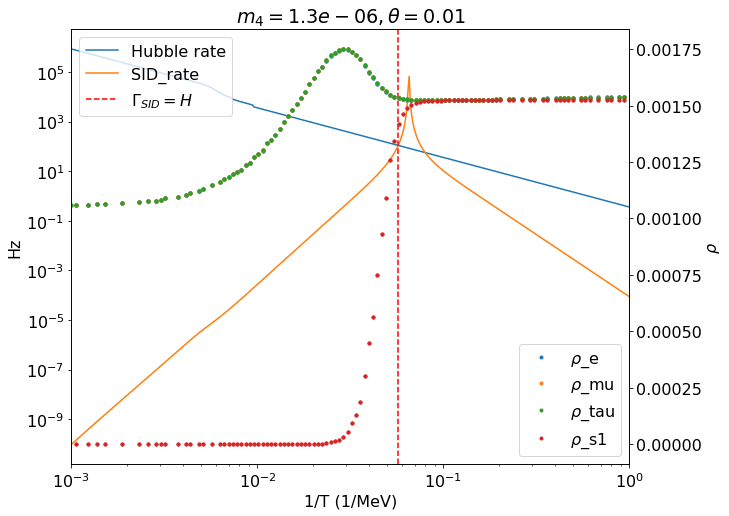

In [36]:
from python.fortepianoOutput import FortEPiaNORun

# Model parameters
params={
"m4": 1.3*10**-6, #MeV
"theta": 0.01,
}

# Analytic results
T = np.logspace(0, 3, 500)
sid = SID_rate(T, params["theta"], params["m4"], 'electron', antineutrino=False)

thermalized, T_thermal, T_freezeout = thermalization_history(10**3, 1, params["theta"], params["m4"], 'electron', antineutrino=False, num_T=1000)

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.loglog(1/T, Hubble_rate(T)*MeVtoHz, label='Hubble rate')
ax1.loglog(1/T, sid*MeVtoHz, label="SID_rate")
#ax1.axvline(1/Tmax(params["m4"]), c='r', ls='--', label="Production peak")
if thermalized:
    ax1.axvline(1/T_thermal, c='r', ls='--', label=r"$\Gamma_{SID} = H$")
ax1.set_ylabel("Hz")
ax1.set_xlabel("1/T (1/MeV)")
ax1.legend(loc=2)

# Fortepiano results
yref = 7 # p=2.86kT according to fd.dat
fp_run = FortEPiaNORun("output/sterile_Garrazio_benchmark/", nnu=4, deltas=False,plots=False)
flavs = ['e', 'mu', 'tau', 's1']
for i, flav in zip(range(4), flavs):
    if i == 4:
        rho_ij = np.zeros(len(x))
    else:
        x, rho_ij = FortEPiaNORun.interpolateRhoIJ(fp_run, i, i, yref, mass=False)
    ax2.semilogx(x, rho_ij, '.', label=r"$\rho$_{}".format(flav))
ax2.set_ylabel(r"$\rho$")            
ax2.legend(loc=4)
plt.xlim(10**-3, 1)
plt.title(r"$m_4={}, \theta={}$".format(params['m4'], params['theta']))
plt.show()

Sterile Garrazio benchmark e3

                & 1.50137 & 1.01721 & 1.01656 & 1.01654 & 0.57268 & 3.62298\\


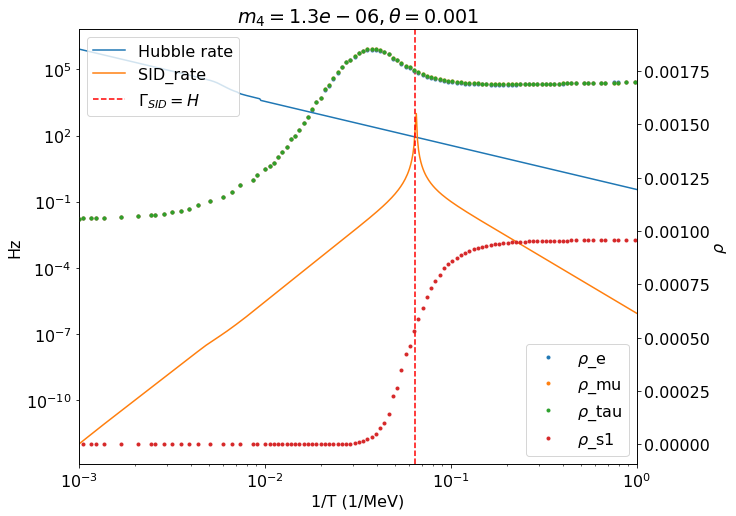

In [134]:
# Model parameters
params={
"m4": 1.3*10**-6, #MeV
"theta": 0.001,
}

# Analytic results
T = np.logspace(0, 3, 500)
sid = SID_rate(T, params["theta"], params["m4"], 'electron', antineutrino=False)

thermalized, T_thermal, T_freezeout = thermalization_history(10**3, 1, params["theta"], params["m4"], 'electron', antineutrino=False, num_T=1000)

fig, ax1 = plt.subplots(figsize=(10,8))
ax2 = ax1.twinx()
ax1.loglog(1/T, Hubble_rate(T)*MeVtoHz, label='Hubble rate')
ax1.loglog(1/T, sid*MeVtoHz, label="SID_rate")
#ax1.axvline(1/Tmax(params["m4"]), c='r', ls='--', label="Production peak")
if thermalized:
    ax1.axvline(1/T_thermal, c='r', ls='--', label=r"$\Gamma_{SID} = H$")
ax1.set_ylabel("Hz")
ax1.set_xlabel("1/T (1/MeV)")
ax1.legend(loc=2)

# Fortepiano results
yref = 7 # p=2.86kT according to fd.dat
fp_run = FortEPiaNORun("output/sterile_Garrazio_benchmark_e3/", nnu=4, deltas=False,plots=False)
flavs = ['e', 'mu', 'tau', 's1']
for i, flav in zip(range(4), flavs):
    if i == 4:
        rho_ij = np.zeros(len(x))
    else:
        x, rho_ij = FortEPiaNORun.interpolateRhoIJ(fp_run, i, i, yref, mass=False)
    ax2.semilogx(x, rho_ij, '.', label=r"$\rho$_{}".format(flav))
ax2.set_ylabel(r"$\rho$")            
ax2.legend(loc=4)
plt.xlim(10**-3, 1)
plt.title(r"$m_4={}, \theta={}$".format(params['m4'], params['theta']))
plt.show()

# Results from Parameter Scan

In [13]:
m5_log_min, m5_log_max = 1, 4
m5_domain = np.logspace(m5_log_min, m5_log_max, 25)
theta_log_min, theta_log_max = -10, -1
theta_domain = np.logspace(theta_log_max, theta_log_min, 25)
tau_bbn = 10 #seconds: from Vincent's paper
sid_results = {
"thermalized": [],
"T_freezeout": [],
"T_thermal": [],
"not_boltzmann_supressed":[],
"decay_before_BBN":[]
}

start = time.time()
for theta in theta_domain:
    for key in sid_results:
        sid_results[key].append([])
    for m5 in m5_domain:
        thermalized, T_thermal, T_freezeout = ec.thermalization_history(10**5, 1, theta, m5, 'electron', antineutrino=False, num_T=1000)
        sid_results['thermalized'][-1].append(thermalized)
        sid_results['T_freezeout'][-1].append(T_freezeout)
        sid_results['T_thermal'][-1].append(T_thermal)
        if thermalized:
            sid_results['not_boltzmann_supressed'][-1].append(T_freezeout>m5)
        else:
            sid_results['not_boltzmann_supressed'][-1].append(True) #Not boltzmann supressed if it never thermalizes
        sid_results['decay_before_BBN'][-1].append(ec.lifetime(m5, theta)/MeVtoHz<tau_bbn)
        
print(time.time()-start)

70.69754076004028


## Conditions that must be met

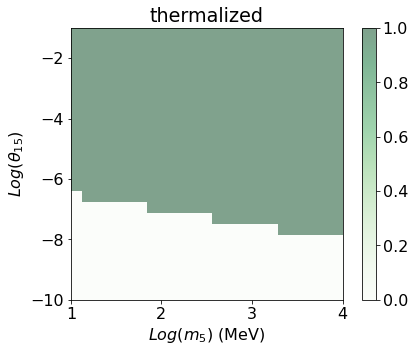

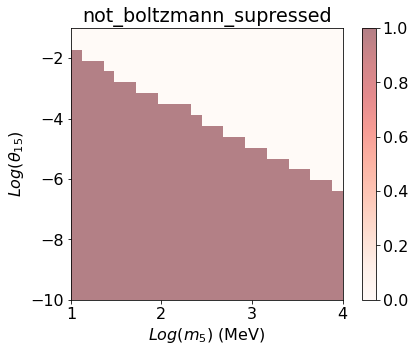

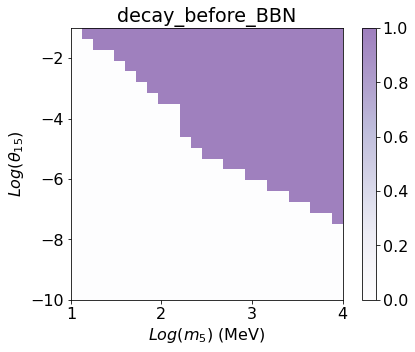

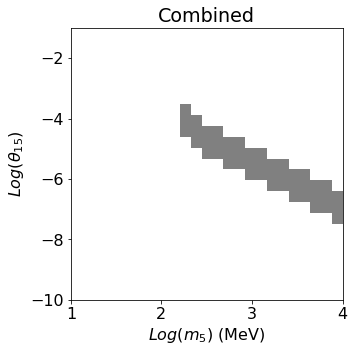

In [46]:
import matplotlib.pyplot as plt
import numpy as np

aspect = (m5_log_max- m5_log_min)/(theta_log_max- theta_log_min)
keys = ['thermalized', 'not_boltzmann_supressed', 'decay_before_BBN']
colors = ['Greens', 'Reds', 'Purples']

for key, color in zip(keys, colors):
    plt.figure(figsize=(7,5))
    plt.imshow(sid_results[key], aspect=aspect, cmap=color, vmin=0, vmax=1, alpha=0.5, 
               extent=[m5_log_min, m5_log_max, theta_log_min, theta_log_max])
    # Add a colorbar to the plot
    plt.colorbar()
    plt.xlabel(r"$Log(m_5)$ (MeV)")
    plt.ylabel(r"$Log(\theta_{15})$")
    plt.title(key)
    plt.show()
    
    
    
plt.figure(figsize=(7,5))
combined = np.array(sid_results['not_boltzmann_supressed']) & np.array(sid_results['decay_before_BBN']) & np.array(sid_results['thermalized'])
plt.imshow(combined, aspect=aspect, cmap='Greys', vmin=0, vmax=1, alpha=0.5,
           extent=[m5_log_min, m5_log_max, theta_log_min, theta_log_max])
plt.xlabel(r"$Log(m_5)$ (MeV)")
plt.ylabel(r"$Log(\theta_{15})$")
plt.title("Combined")
plt.show()

# Check individual equations

## Relativistic DOFs

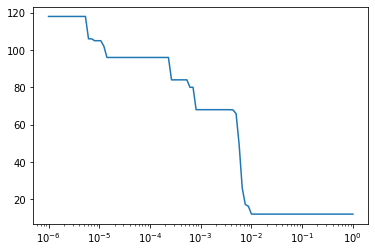

In [2]:
Tdom = np.logspace(6, 0, 100)
dofs = [ec.compute_SM_relativistic_dof(T) for T in Tdom]
plt.semilogx(1/Tdom,dofs)
plt.show()

## Neutrino thermal scattering coefficients

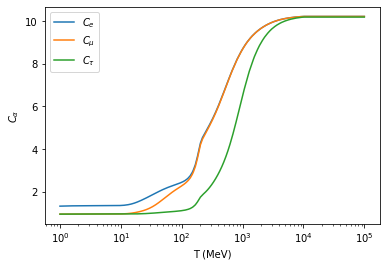

In [3]:
# Compare to figure 10 in Dodelson-Widrow production of sterile neutrino DM with non-trivial initial abundance

plt.semilogx(np.logspace(0, 5, 300), ec.scattering_coeffs(np.logspace(0, 5, 300), 'electron'), label=r'$C_e$')
plt.semilogx(np.logspace(0, 5, 300), ec.scattering_coeffs(np.logspace(0, 5, 300), 'muon'), label=r'$C_{\mu}$')
plt.semilogx(np.logspace(0, 5, 300), ec.scattering_coeffs(np.logspace(0, 5, 300), 'tau'), label=r'$C_{\tau}$')
plt.ylabel(r"$C_\alpha$")
plt.xlabel("T (MeV)")
plt.legend()
plt.show()

## Check DW SID rate vs the more detailed production rate

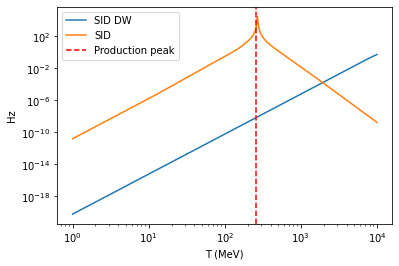

In [7]:
params={
"m4": 7*10**-3, #MeV
"theta": 0.5*np.sqrt(7*10**-11),
}

T = np.logspace(0, 4, 500)

sid_DW = ec.SID_rate_DW(T, params["theta"], params["m4"])
sid = ec.SID_rate(T, params["theta"], params["m4"], 'electron', antineutrino=False)

plt.loglog(T, sid_DW*MeVtoHz, label='SID DW')
plt.loglog(T, sid*MeVtoHz, label="SID")
plt.axvline(ec.Tmax(params["m4"]), c='r', ls='--', label="Production peak")
plt.ylabel("Hz")
plt.xlabel("T (MeV)")
plt.legend()
plt.show()

## Generic Production Rate

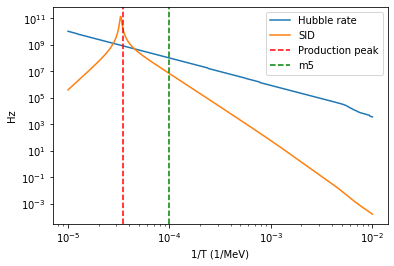

In [8]:
params={
"m5": 10**4, #MeV
"theta": 10**-7,
}

T = np.logspace(2, 5, 500)

sid = ec.SID_rate(T, params["theta"], params["m5"], 'electron', antineutrino=False)

plt.loglog(1/T, ec.Hubble_rate(T)*MeVtoHz, label='Hubble rate')
plt.loglog(1/T, sid*MeVtoHz, label="SID")
plt.axvline(1/ec.Tmax(params["m5"]), c='r', ls='--', label="Production peak")
plt.axvline(1/params["m5"], c='g', ls='--', label="m5")
plt.ylabel("Hz")
plt.xlabel("1/T (1/MeV)")
plt.legend()
plt.show()

## Lifetimes

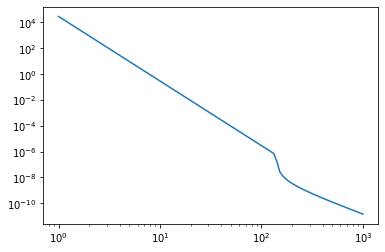

In [9]:
Tdomain = np.logspace(0, 3, 100)
lifetimes = [ec.lifetime(T, np.pi/2)/MeVtoHz for T in Tdomain]
plt.loglog(Tdomain, lifetimes)
plt.show()

## Check the lepton potential pre-factors

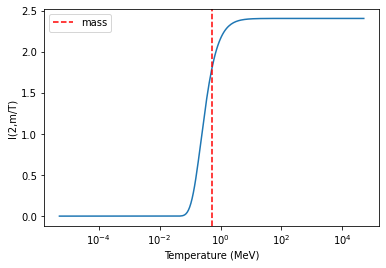

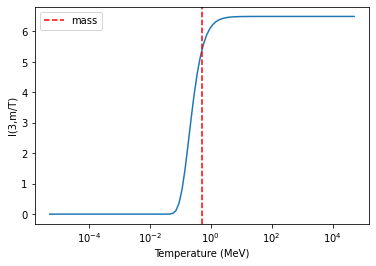

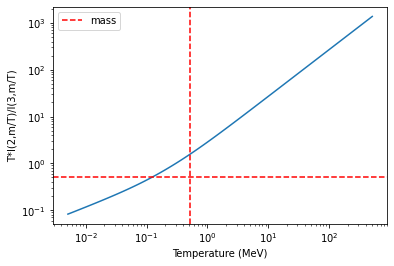

In [11]:
factors = []
T_domain = m_e*np.logspace(-5, 5, 251)
for T in T_domain:
    factors.append(ec.lepton_integral_interp(2, m_e/T))
plt.semilogx(T_domain, factors)
plt.ylabel("I(2,m/T)")
plt.xlabel("Temperature (MeV)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.legend()
plt.show()


factors = []
T_domain = m_e*np.logspace(-5, 5, 100)
for T in T_domain:
    factors.append(ec.lepton_integral_interp(3, m_e/T))
plt.figure()
plt.semilogx(T_domain, factors)
plt.ylabel("I(3,m/T)")
plt.xlabel("Temperature (MeV)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.legend()
plt.show()

factors = []
plt.figure()

# The average energy should converge to the mass: but it doesn't
# because the integral results just get too small. 
T_domain = m_e*np.logspace(-2, 3, 100)
for T in T_domain:
    factors.append(T*ec.lepton_integral_interp(3, m_e/T)/ec.lepton_integral_interp(2, m_e/T))
plt.loglog(T_domain, factors)

plt.xlabel("Temperature (MeV)")
plt.ylabel("T*I(2,m/T)/I(3,m/T)")
plt.axvline(m_e, ls='--', c='r', label='mass')
plt.axhline(m_e, ls='--', c='r')
plt.legend()
plt.show()

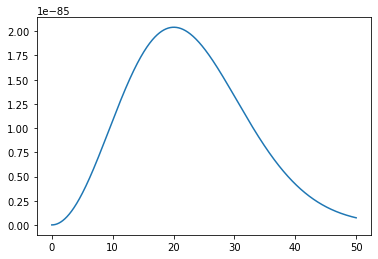

In [36]:
n=2
x=200
y_dom = np.linspace(0.001,50, 1000)
plt.plot(y_dom, y_dom**n/(np.exp(np.sqrt(x**2 + y_dom**2))-1))